<a href="https://colab.research.google.com/github/muhamadarif09/1461900226_MuhammadArif_KCBV/blob/main/ETS_GEMPA_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Anggota Kelompok
1. Febriansyah Dwi K (1461900182)
2. Ququh Imanuddin (1461900213)
3. Lintang Ragadanu (1461900219)
4. Muhammad Arif Fajriyansah (1461900226)

# Image classification

Link Dataset : [Dataset](https://drive.google.com/u/0/uc?id=1W5Iz8IE0Q__gGnbjzqBiJM0sLX6-_UbS&export=download)

### Import Library

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import files
file = files.upload()

Saving Gempa.rar to Gempa.rar


In [3]:
!unrar x -Y "/content/Gempa.rar" "/content/datagempa/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Gempa.rar

Creating    /content/datagempa                                        OK
Creating    /content/datagempa/Gempa                                  OK
Creating    /content/datagempa/Gempa/Hybrid                           OK
Extracting  /content/datagempa/Gempa/Hybrid/2022-05-05_13h59_51.png        2%  OK 
Extracting  /content/datagempa/Gempa/Hybrid/2022-05-05_14h03_35.png       10% 18%  OK 
Extracting  /content/datagempa/Gempa/Hybrid/2022-05-05_14h03_44.png       27% 33%  OK 
Extracting  /content/datagempa/Gempa/Hybrid/2022-05-05_14h03_50.png       41% 49% 51%  OK 
Creating    /content/datagempa/Gempa/Low                              OK
Extracting  /content/datagempa/Gempa/Low/2022-05-05_13h59_07.png          54%  OK 
Extracting  /content/datagempa/Gempa/Low/2022-05-05_13h59_47.png          57%  OK 
Extracting  /conten

In [4]:
import pathlib
data = pathlib.Path('/content/datagempa/Gempa') 
count = len(list(data.glob('*/*.png')))
count

14

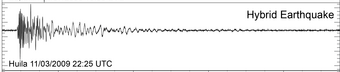

In [5]:
Hybrid = list(data.glob('Hybrid/*'))
PIL.Image.open(str(Hybrid[0]))

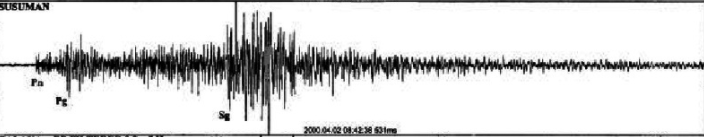

In [6]:
PIL.Image.open(str(Hybrid[1]))

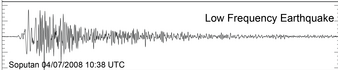

In [7]:
Low = list(data.glob('Low/*'))
PIL.Image.open(str(Low[0]))

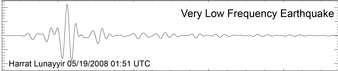

In [8]:
PIL.Image.open(str(Low[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

### Bagi Data Training dan Tes

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14 files belonging to 4 classes.
Using 12 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14 files belonging to 4 classes.
Using 2 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['Hybrid', 'Low', 'Tektonik', 'Tremor']


### Visualisasi Data

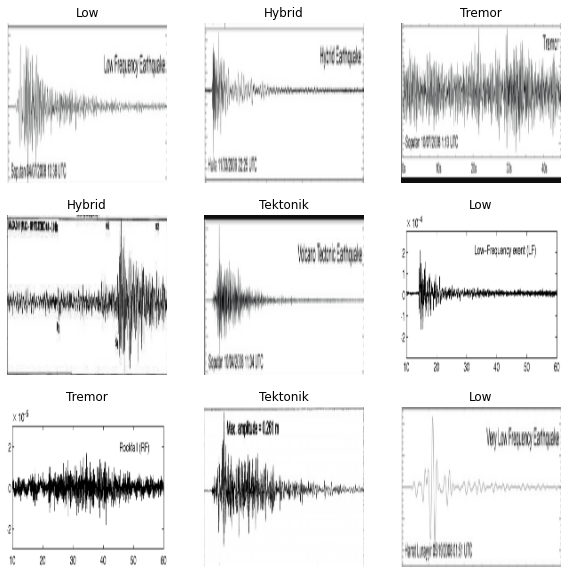

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(12, 180, 180, 3)
(12,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standarisasi Data

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0018871679 1.0


### Pembuatan Model Neural Network

In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training Model

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 1.4317 - accuracy: 0.3333 - val_loss: 12.8393 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 9.2447 - accuracy: 0.2500 - val_loss: 8.6781 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 6.4219 - accuracy: 0.2500 - val_loss: 9.3018 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 6.8705 - accuracy: 0.3333 - val_loss: 5.6455 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 4.2514 - accuracy: 0.3333 - val_loss: 2.7480 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 2.1407 - accuracy: 0.3333 - val_loss: 1.4690 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 1.3756 - accuracy: 0.2500 - val_loss: 1.4102 - val_accuracy: 0.0000e+00
Epoch 

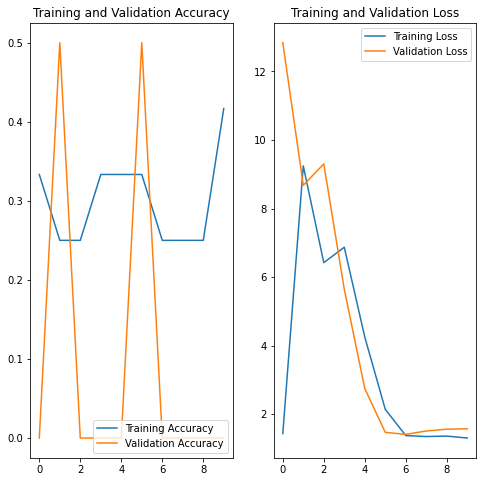

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

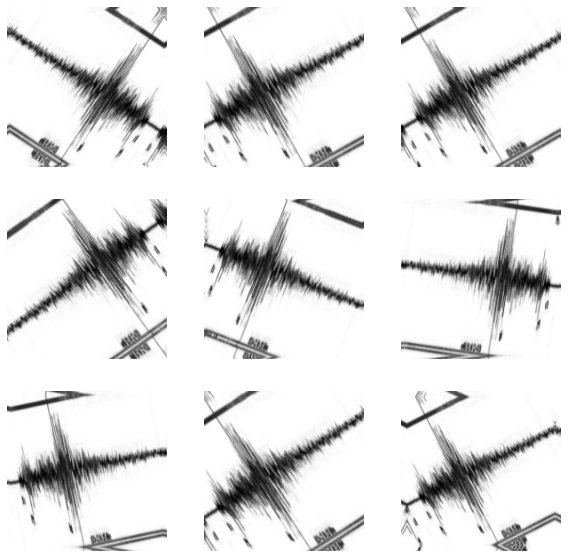

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## DropOut
membentuk Jaringan Baru

In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 1.3817 - accuracy: 0.2500 - val_loss: 2.0496 - val_accuracy: 0.0000e+00
Epoch 2/15
1/1 [==============================] - 0s 45ms/step - loss: 1.4996 - accuracy: 0.3333 - val_loss: 1.0303 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 0s 44ms/step - loss: 1.7118 - accuracy: 0.1667 - val_loss: 1.4203 - val_accuracy: 0.0000e+00
Epoch 4/15
1/1 [==============================] - 0s 37ms/step - loss: 1.4331 - accuracy: 0.2500 - val_loss: 1.5399 - val_accuracy: 0.0000e+00
Epoch 5/15
1/1 [==============================] - 0s 40ms/step - loss: 1.3525 - accuracy: 0.2500 - val_loss: 1.5446 - val_accuracy: 0.0000e+00
Epoch 6/15
1/1 [==============================] - 0s 38ms/step - loss: 1.3257 - accuracy: 0.3333 - val_loss: 1.5047 - val_accuracy: 0.0000e+00
Epoch 7/15
1/1 [==============================] - 0s 41ms/step - loss: 1.3032 - accuracy: 0.3333 - val_loss: 1.4801 - val_accuracy: 0.0000e+00
Epoch

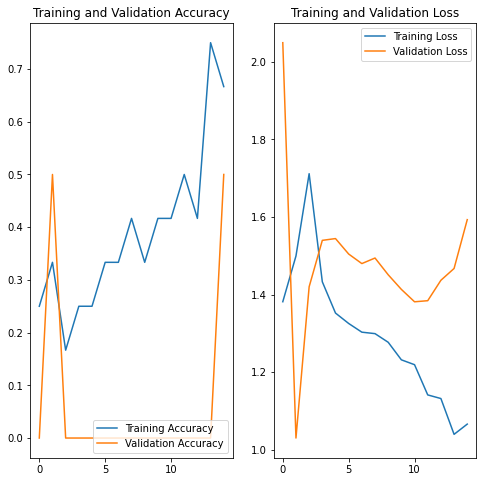

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# upload file yang sudah diunduh
# file akan disimpan sesuai dengan nama file yang diunggah
from google.colab import files
file = files.upload()

Saving tes_seismograf.jpg to tes_seismograf.jpg


## Hasil Prediksi Data Baru

In [43]:
gempa = pathlib.Path('/content/tes_seismograf.jpg')
img = tf.keras.utils.load_img(
    gempa, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Gambar ini terdeteksi level {} dengan presentase sebanyak {:.2f} %"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Gambar ini terdeteksi level Tremor dengan presentase sebanyak 78.31 %
